# LGBM




# Import Necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, validation_curve, cross_validate, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, RobustScaler, MinMaxScaler, StandardScaler
from sklearn import model_selection

!pip install lightgbm
from lightgbm import LGBMRegressor

from xgboost import XGBRegressor
import pickle
import joblib



# Settings
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.width", 500)

import warnings
warnings.filterwarnings("ignore")

# Import Dataset

In [2]:
adv = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/datasets/Hitters[1].csv")
df = adv.copy()
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


# General Information About to Dataset

In [3]:
def check_df(dataframe, head=5):
    print(20*"#", "HEAD", 20*"#")
    print(dataframe.head(head))
    print(20*"#", "TAIL", 20*"#")
    print(dataframe.tail(head))
    print(20*"#", "SHAPE", 20*"#")
    print(dataframe.shape)
    print(20*"#", "TYPES", 20*"#")
    print(dataframe.dtypes)
    print(20*"#", "NA", 20*"#")
    print(dataframe.isnull().sum())
    print(20*"#", "QUARTILES", 20*"#")
    print(dataframe.describe([0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]).T)

In [4]:
check_df(df)

#################### HEAD ####################
   AtBat  Hits  HmRun  Runs  RBI  Walks  Years  CAtBat  CHits  CHmRun  CRuns  CRBI  CWalks League Division  PutOuts  Assists  Errors  Salary NewLeague
0    293    66      1    30   29     14      1     293     66       1     30    29      14      A        E      446       33      20     NaN         A
1    315    81      7    24   38     39     14    3449    835      69    321   414     375      N        W      632       43      10   475.0         N
2    479   130     18    66   72     76      3    1624    457      63    224   266     263      A        W      880       82      14   480.0         A
3    496   141     20    65   78     37     11    5628   1575     225    828   838     354      N        E      200       11       3   500.0         N
4    321    87     10    39   42     30      2     396    101      12     48    46      33      N        E      805       40       4    91.5         N
#################### TAIL ####################


# Analysis of Catgeorical and Numerical Variables

In [5]:
def grab_col_names(dataframe, cat_th=10, car_th=20, report=False):
    # category
    cat_cols = [col for col in dataframe.columns if str(dataframe[col].dtypes) in  ["category", "object", "bool"]]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes in ["uint8", "int64", "float64"]]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and str(dataframe[col].dtypes) in ["category", "object"]]
    cat_cols = cat_cols + num_but_cat
    # numerical
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes in ["uint8", "int64", "float64"]]
    num_cols = [col for col in num_cols if col not in cat_cols]
    # report
    if report:
        print(f"Observation: {dataframe.shape[0]}")
        print(f"Variables: {dataframe.shape[1]}")
        print(f"Categrical Columns: {len(cat_cols)}")
        print(f"Numerical Columns: {len(num_cols)}")
        print(f"Categorical But Cardinality: {len(cat_but_car)}")
        print(f"Numerical But Categorical: {len(num_but_cat)}")
    return cat_cols, num_but_cat, cat_but_car, num_cols

In [6]:
cat_cols, num_but_cat, cat_but_car, num_cols = grab_col_names(df, report=True)

Observation: 322
Variables: 20
Categrical Columns: 3
Numerical Columns: 17
Categorical But Cardinality: 0
Numerical But Categorical: 0


In [7]:
def num_summary(dataframe, col_name, plot=False):
    print(20*"#", col_name, 20*"#")
    quantiles = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]
    print(dataframe[col_name].describe(quantiles).T)
    if plot:
        dataframe[col_name].hist(bins=20)
        plt.xlabel(col_name)
        plt.ylabel(col_name)
        plt.show()

In [8]:
def num_summary_df(dataframe):
    cat_cols, num_but_cat, cat_but_car, num_cols = grab_col_names(dataframe)
    for col in num_cols:
        num_summary(dataframe, col, plot=True)

#################### AtBat ####################
count    322.000000
mean     380.928571
std      153.404981
min       16.000000
1%        20.420000
5%       161.000000
10%      194.100000
20%      221.800000
30%      281.300000
40%      321.800000
50%      379.500000
60%      430.200000
70%      490.000000
80%      535.600000
90%      584.900000
95%      609.900000
99%      658.590000
max      687.000000
Name: AtBat, dtype: float64


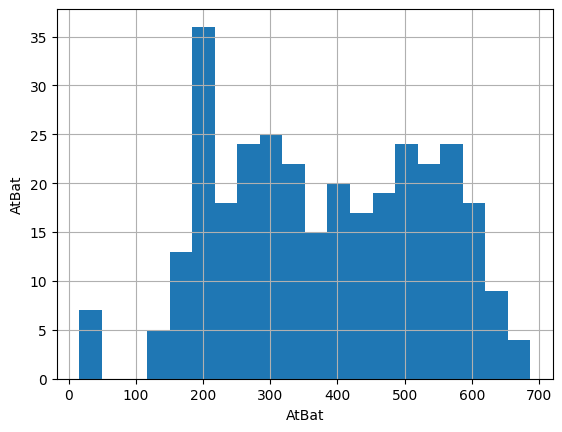

#################### Hits ####################
count    322.000000
mean     101.024845
std       46.454741
min        1.000000
1%         4.420000
5%        39.000000
10%       45.100000
20%       57.000000
30%       70.000000
40%       82.000000
50%       96.000000
60%      113.000000
70%      128.700000
80%      144.000000
90%      163.000000
95%      174.000000
99%      210.790000
max      238.000000
Name: Hits, dtype: float64


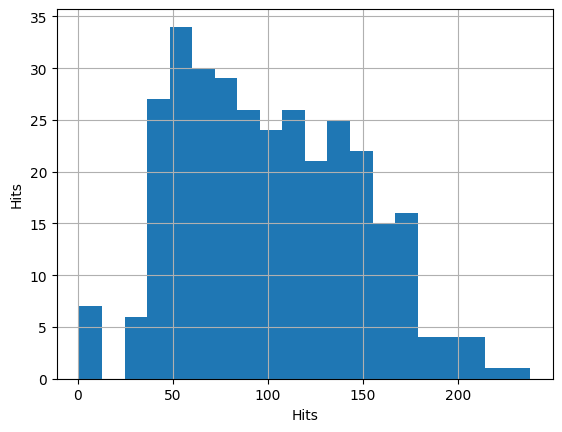

#################### HmRun ####################
count    322.000000
mean      10.770186
std        8.709037
min        0.000000
1%         0.000000
5%         0.000000
10%        1.000000
20%        3.000000
30%        5.000000
40%        6.000000
50%        8.000000
60%       10.600000
70%       14.000000
80%       18.000000
90%       24.000000
95%       28.950000
99%       33.000000
max       40.000000
Name: HmRun, dtype: float64


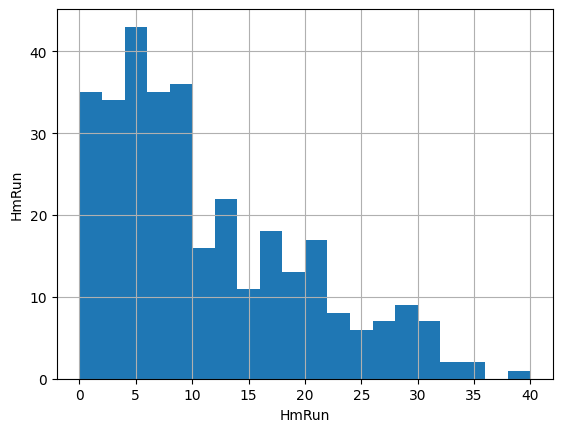

#################### Runs ####################
count    322.000000
mean      50.909938
std       26.024095
min        0.000000
1%         1.210000
5%        17.000000
10%       20.100000
20%       27.000000
30%       33.000000
40%       41.000000
50%       48.000000
60%       55.600000
70%       66.000000
80%       75.800000
90%       89.000000
95%       94.000000
99%      107.790000
max      130.000000
Name: Runs, dtype: float64


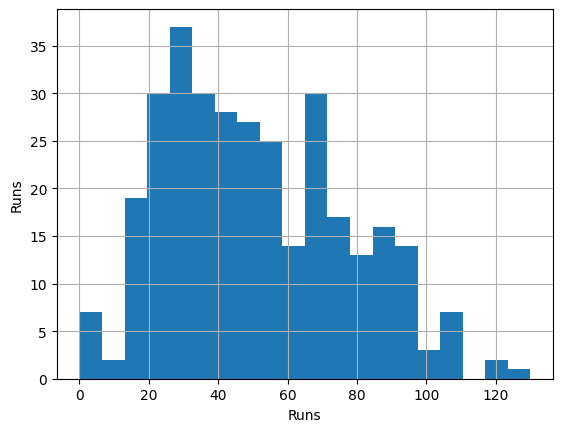

#################### RBI ####################
count    322.000000
mean      48.027950
std       26.166895
min        0.000000
1%         2.000000
5%        14.000000
10%       19.000000
20%       26.000000
30%       30.000000
40%       36.400000
50%       44.000000
60%       49.000000
70%       58.000000
80%       73.000000
90%       86.000000
95%       96.000000
99%      112.370000
max      121.000000
Name: RBI, dtype: float64


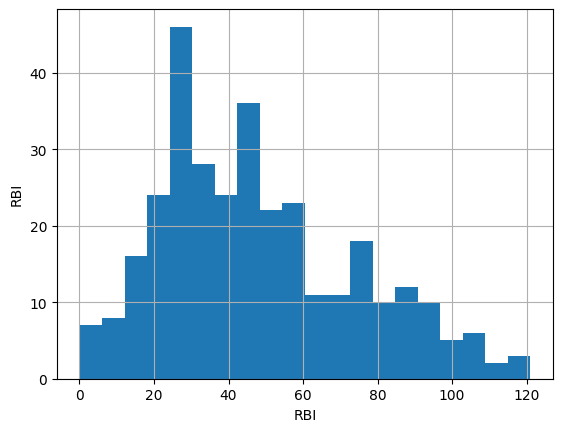

#################### Walks ####################
count    322.000000
mean      38.742236
std       21.639327
min        0.000000
1%         1.000000
5%        11.050000
10%       15.000000
20%       20.000000
30%       24.000000
40%       30.000000
50%       35.000000
60%       40.000000
70%       48.700000
80%       59.000000
90%       69.900000
95%       78.000000
99%       93.580000
max      105.000000
Name: Walks, dtype: float64


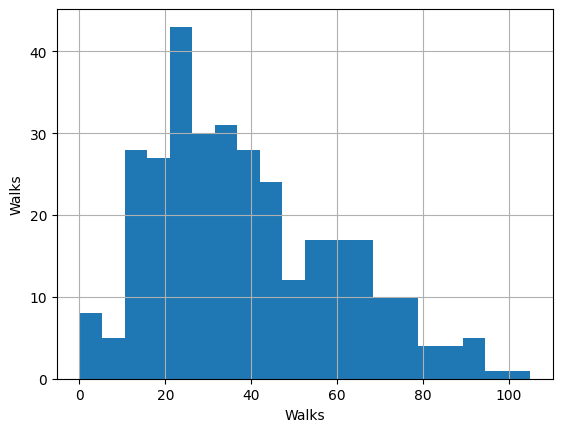

#################### Years ####################
count    322.000000
mean       7.444099
std        4.926087
min        1.000000
1%         1.000000
5%         1.000000
10%        2.000000
20%        3.000000
30%        4.000000
40%        5.000000
50%        6.000000
60%        7.600000
70%       10.000000
80%       12.000000
90%       15.000000
95%       17.000000
99%       19.790000
max       24.000000
Name: Years, dtype: float64


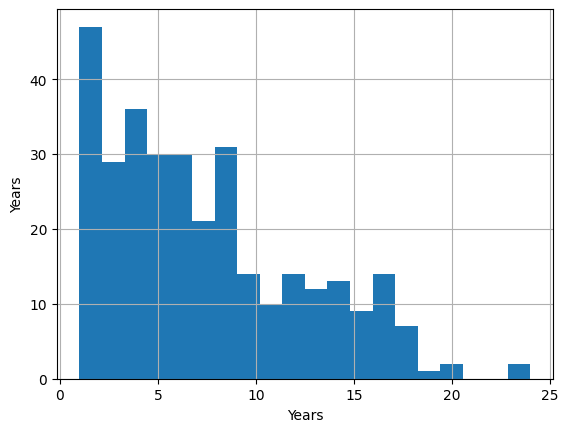

#################### CAtBat ####################
count      322.00000
mean      2648.68323
std       2324.20587
min         19.00000
1%          41.00000
5%         216.50000
10%        342.20000
20%        667.60000
30%        963.40000
40%       1402.20000
50%       1928.00000
60%       2654.00000
70%       3365.00000
80%       4483.00000
90%       6123.40000
95%       7125.60000
99%       8749.97000
max      14053.00000
Name: CAtBat, dtype: float64


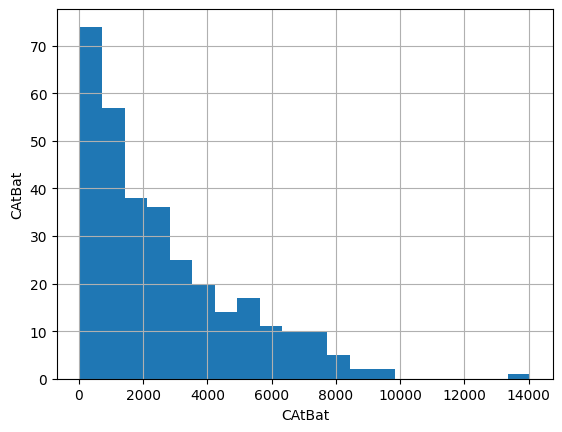

#################### CHits ####################
count     322.000000
mean      717.571429
std       654.472627
min         4.000000
1%          9.840000
5%         54.000000
10%        86.000000
20%       164.600000
30%       238.000000
40%       355.800000
50%       508.000000
60%       708.200000
70%       911.100000
80%      1229.200000
90%      1659.600000
95%      2017.150000
99%      2500.340000
max      4256.000000
Name: CHits, dtype: float64


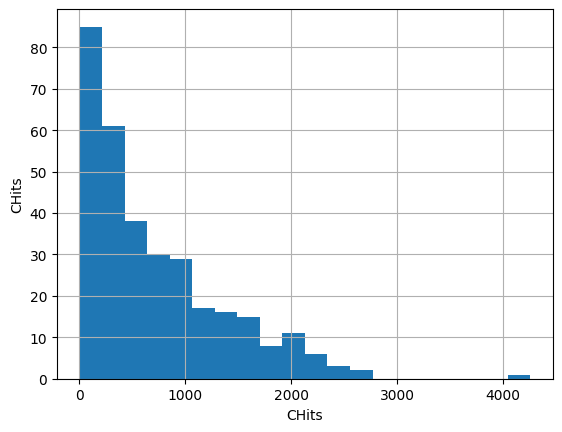

#################### CHmRun ####################
count    322.000000
mean      69.490683
std       86.266061
min        0.000000
1%         0.000000
5%         2.000000
10%        4.000000
20%       10.200000
30%       16.300000
40%       27.400000
50%       37.500000
60%       51.200000
70%       72.400000
80%      103.800000
90%      194.900000
95%      265.650000
99%      373.120000
max      548.000000
Name: CHmRun, dtype: float64


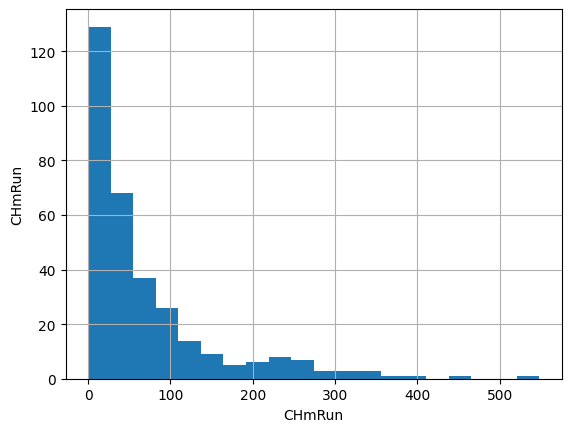

#################### CRuns ####################
count     322.000000
mean      358.795031
std       334.105886
min         1.000000
1%          3.630000
5%         27.000000
10%        38.100000
20%        80.400000
30%       117.300000
40%       181.000000
50%       247.000000
60%       333.000000
70%       443.400000
80%       627.200000
90%       895.700000
95%      1032.300000
99%      1174.370000
max      2165.000000
Name: CRuns, dtype: float64


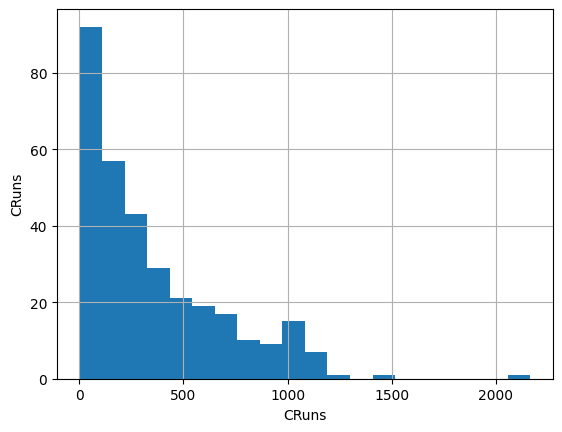

#################### CRBI ####################
count     322.000000
mean      330.118012
std       333.219617
min         0.000000
1%          4.630000
5%         22.050000
10%        34.100000
20%        70.200000
30%       106.300000
40%       149.000000
50%       220.500000
60%       303.600000
70%       379.100000
80%       496.200000
90%       861.600000
95%      1071.750000
99%      1310.850000
max      1659.000000
Name: CRBI, dtype: float64


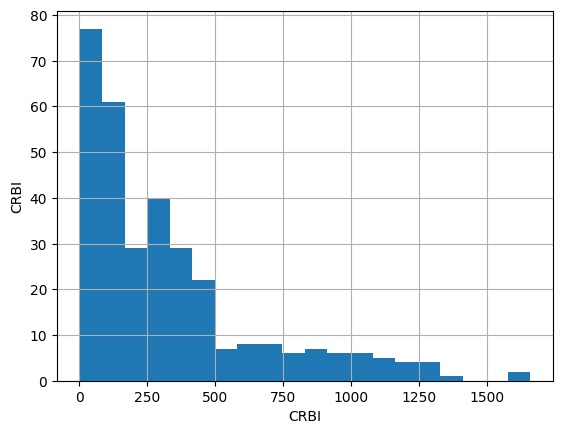

#################### CWalks ####################
count     322.000000
mean      260.239130
std       267.058085
min         0.000000
1%          4.000000
5%         15.050000
10%        30.100000
20%        55.000000
30%        82.000000
40%       117.400000
50%       170.500000
60%       226.600000
70%       300.700000
80%       421.000000
90%       643.900000
95%       817.600000
99%      1139.140000
max      1566.000000
Name: CWalks, dtype: float64


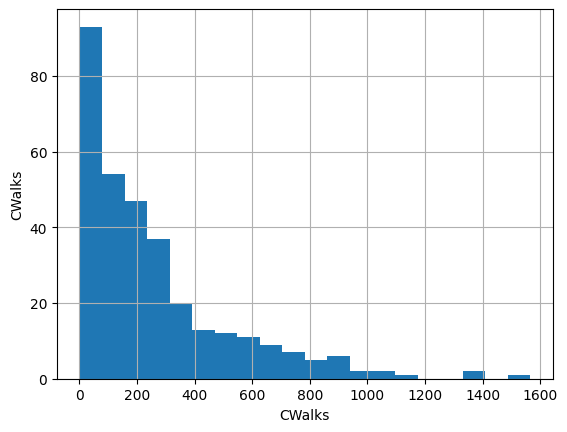

#################### PutOuts ####################
count     322.000000
mean      288.937888
std       280.704614
min         0.000000
1%          0.000000
5%         33.200000
10%        62.200000
20%        99.600000
30%       132.000000
40%       167.000000
50%       212.000000
60%       257.400000
70%       303.000000
80%       365.800000
90%       685.600000
95%       910.650000
99%      1301.190000
max      1378.000000
Name: PutOuts, dtype: float64


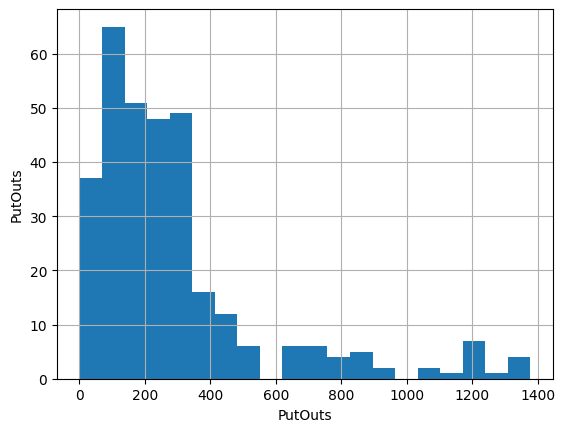

#################### Assists ####################
count    322.000000
mean     106.913043
std      136.854876
min        0.000000
1%         0.000000
5%         0.000000
10%        2.000000
20%        5.200000
30%        9.000000
40%       15.400000
50%       39.500000
60%       76.800000
70%      134.800000
80%      210.800000
90%      353.300000
95%      431.450000
99%      478.160000
max      492.000000
Name: Assists, dtype: float64


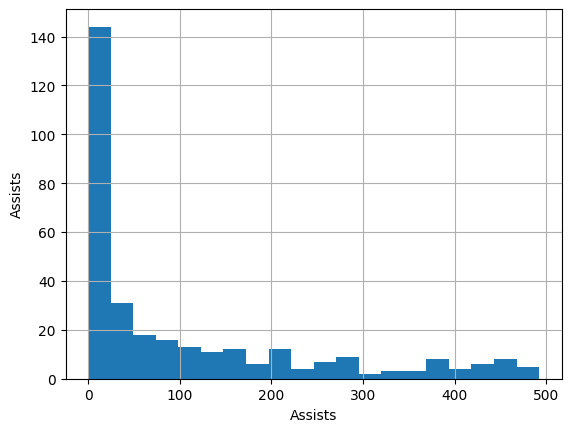

#################### Errors ####################
count    322.000000
mean       8.040373
std        6.368359
min        0.000000
1%         0.000000
5%         0.000000
10%        1.000000
20%        3.000000
30%        4.000000
40%        5.000000
50%        6.000000
60%        8.000000
70%       10.000000
80%       13.000000
90%       17.000000
95%       20.000000
99%       25.790000
max       32.000000
Name: Errors, dtype: float64


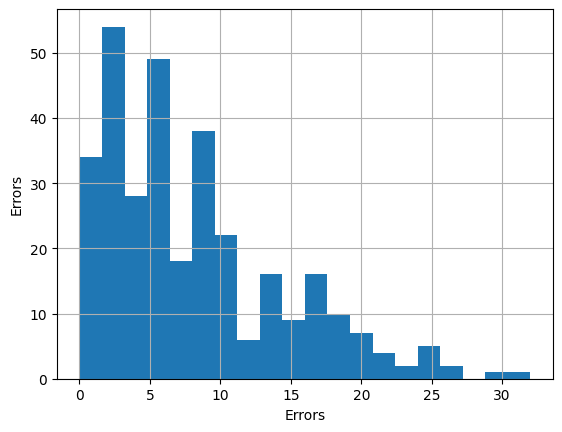

#################### Salary ####################
count     263.000000
mean      535.925882
std       451.118681
min        67.500000
1%         70.000000
5%         86.600000
10%       100.000000
20%       155.000000
30%       221.000000
40%       300.000000
50%       425.000000
60%       538.000000
70%       700.000000
80%       809.000000
90%      1048.666600
95%      1346.000000
99%      2032.886540
max      2460.000000
Name: Salary, dtype: float64


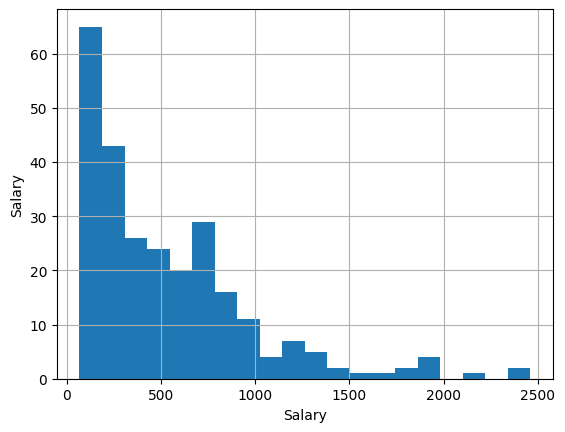

In [9]:
num_summary_df(df)

In [10]:
def plot_num_summary(dataframe):
    cat_cols, num_but_cat, cat_but_car, num_cols = grab_col_names(dataframe)
    num_plots = len(num_cols)
    rows = math.ceil(num_plots/2)
    cols = 2 if num_plots > 1 else 1
    plt.figure(figsize=(10*cols, 4*rows))
    for index, col in enumerate(num_cols):
        plt.subplot(rows, cols, index+1)
        plt.tight_layout()
        dataframe[col].hist(bins=20)
        plt.title(col)

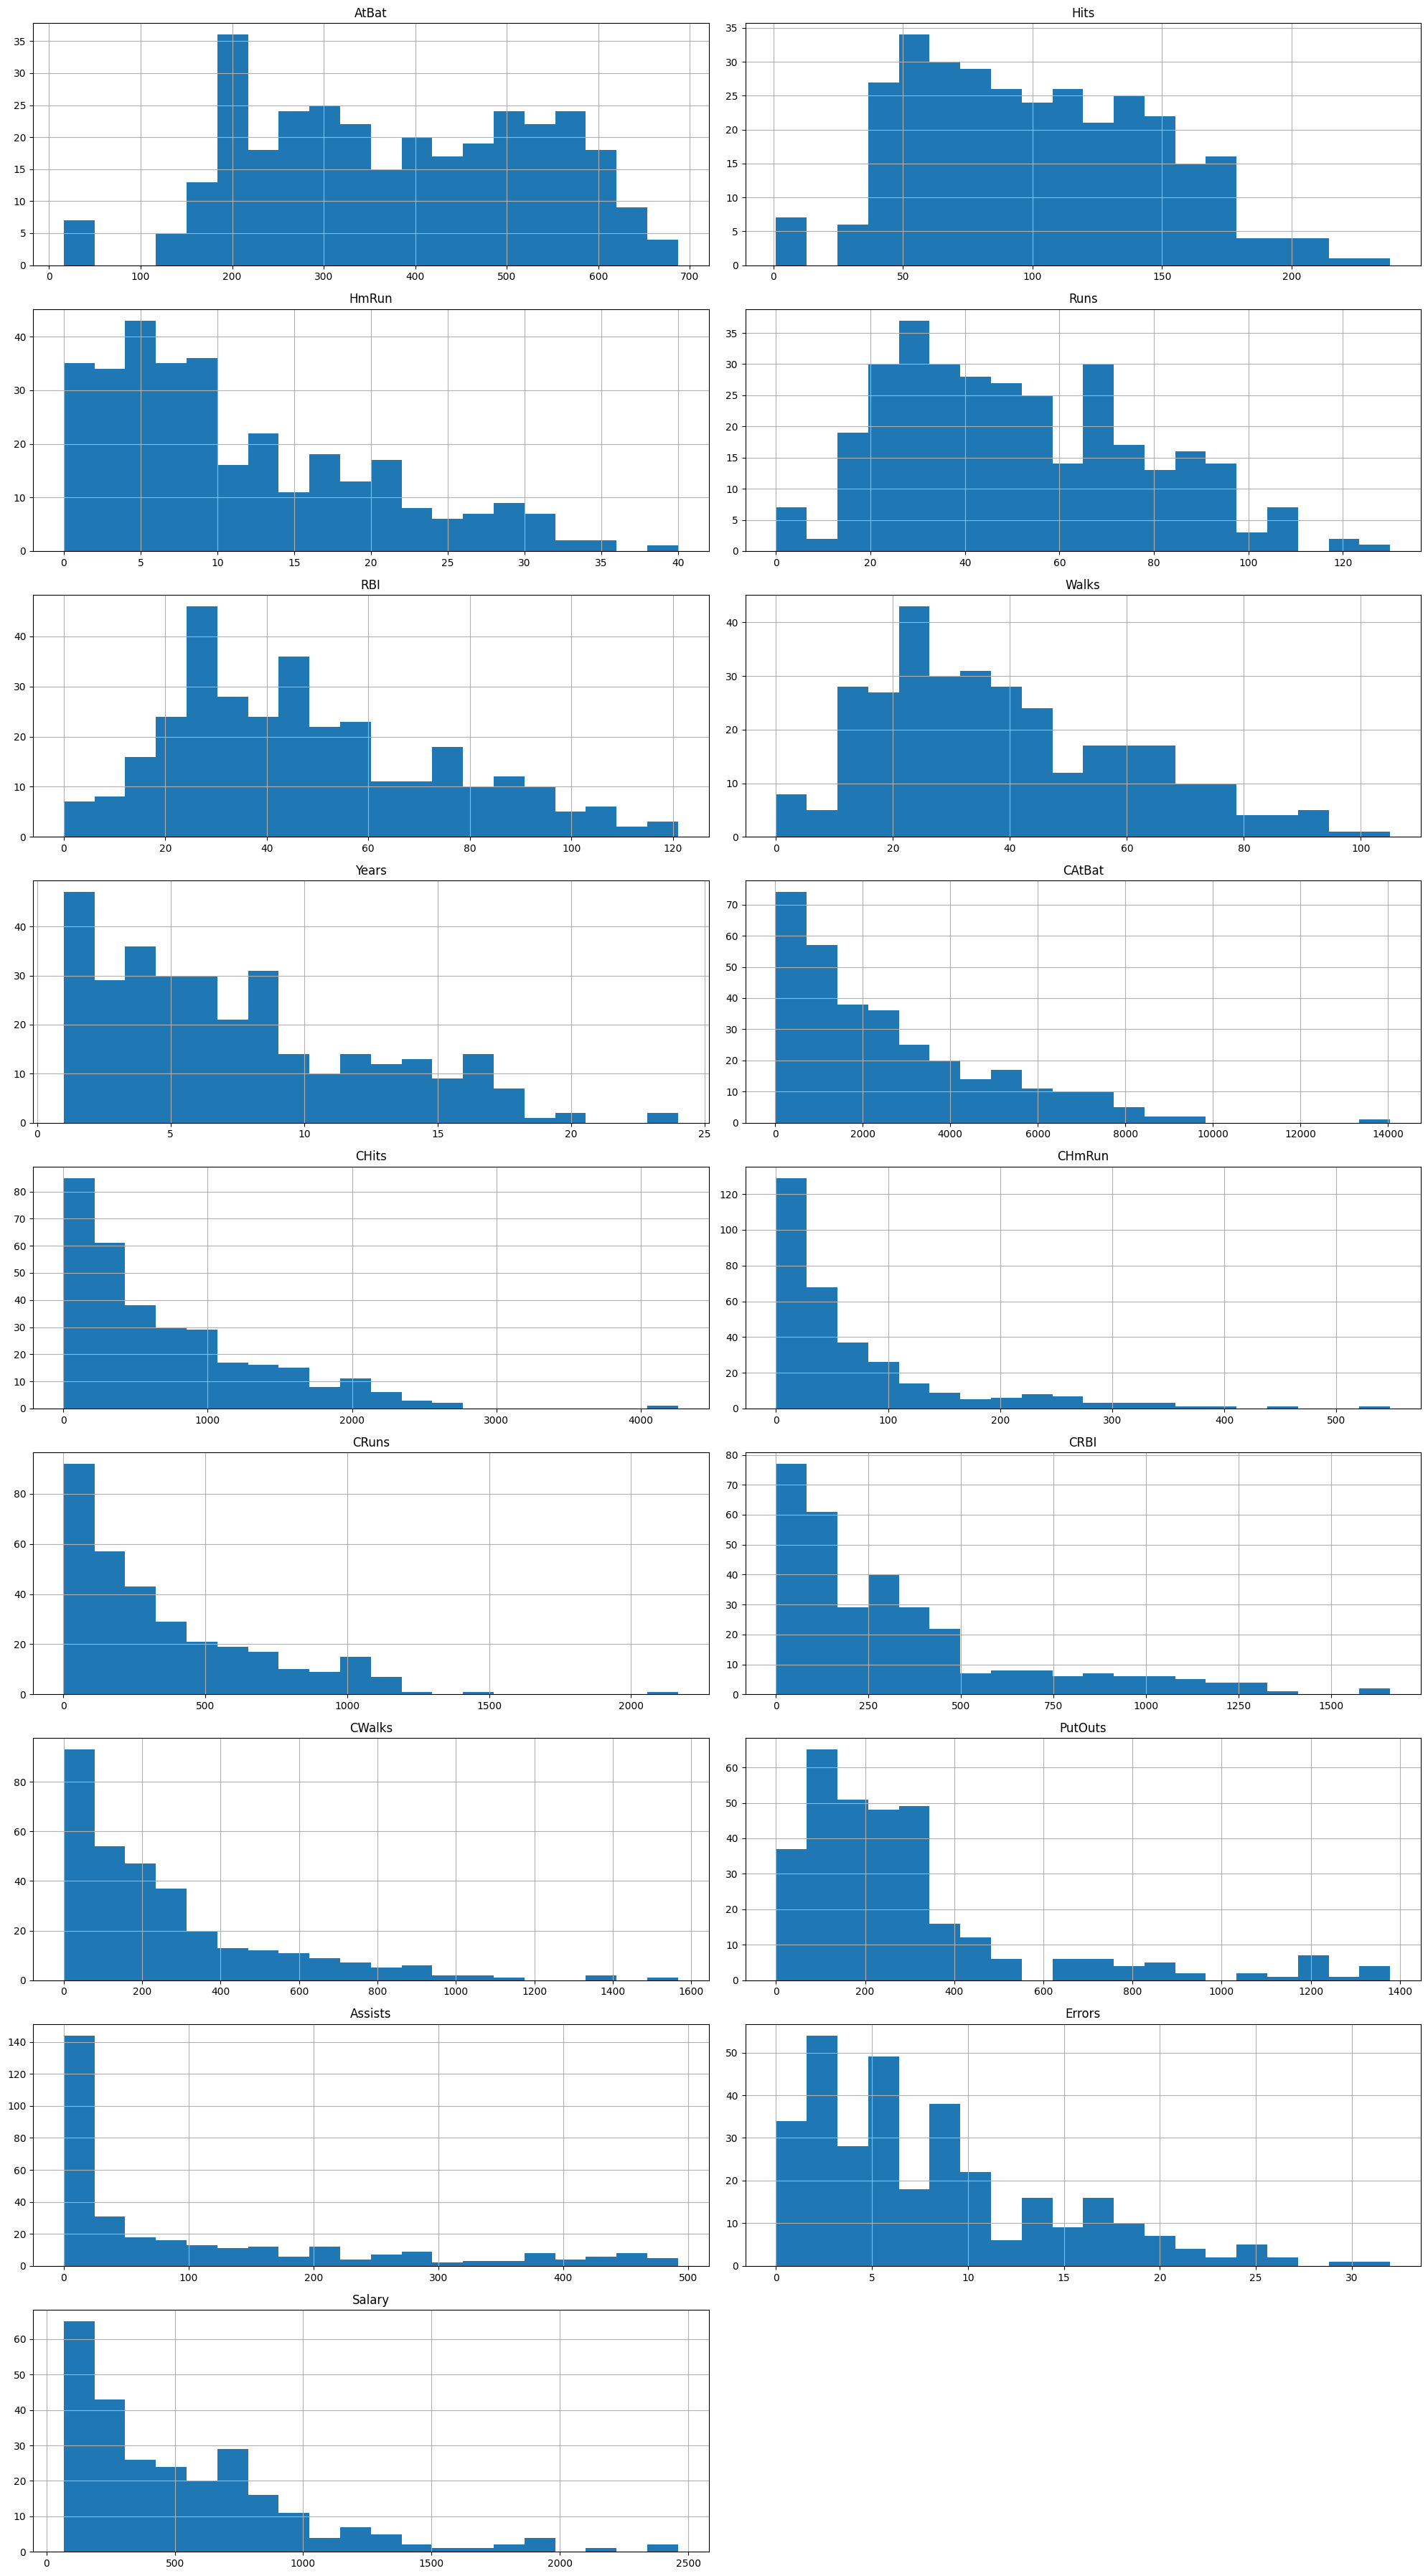

In [11]:
plot_num_summary(df)

# Correlation Analysis

In [12]:
def high_correlated_cols(dataframe, corr_th=0.9, remove=False, plot=False):
    num_cols = [col for col in dataframe.columns if str(dataframe[col].dtypes) in ["uint8", "int64", "float64"]]
    corr = dataframe[num_cols].corr()
    corr_matrix = corr.abs()
    upper_triangle_matrix = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    drop_list = [col for col in upper_triangle_matrix.columns if any(upper_triangle_matrix[col] > corr_th)]
    if drop_list == []:
        print(20*"#", "After correlation analaysis, you do not need to remove variables", 20*"#")
    if remove:
        dataframe = dataframe.drop(drop_list, axis=1)
    if plot:
        num_cols = [col for col in dataframe.columns if str(dataframe[col].dtypes) in ["uint8", "int64", "float64"]]
        sns.set(rc={'figure.figsize': (18, 13)})
        sns.heatmap(dataframe[num_cols].corr(), cmap="RdBu", annot=True, fmt=".2f")
        plt.show()
    return drop_list

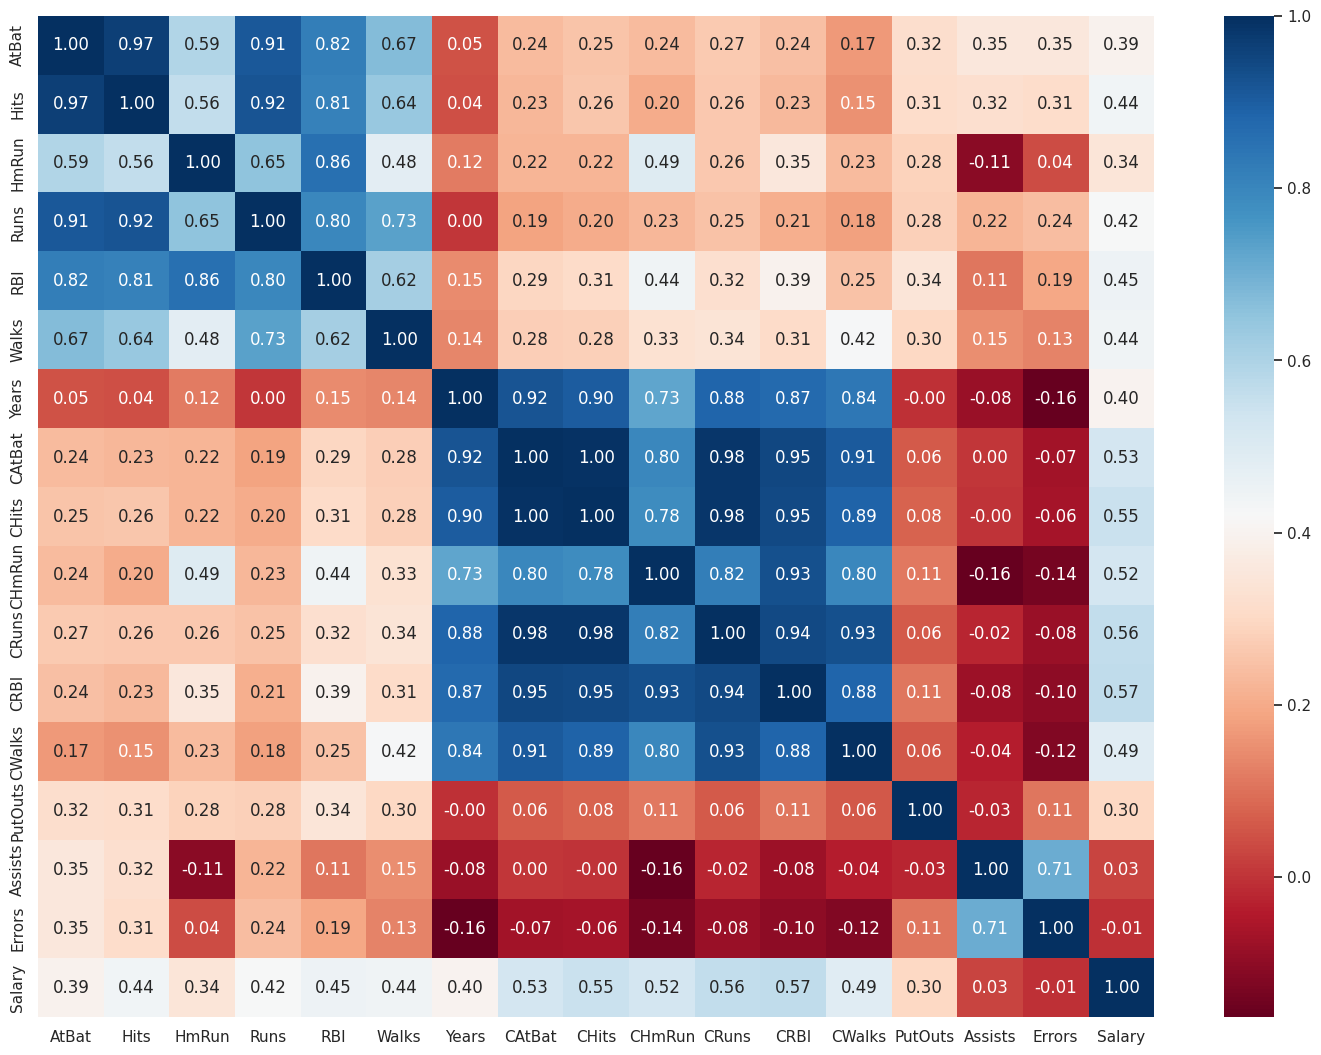

In [13]:
drop_list = high_correlated_cols(df, remove=False, plot=True)

In [14]:
drop_list

['Hits', 'Runs', 'CAtBat', 'CHits', 'CRuns', 'CRBI', 'CWalks']

# Missing Value Analysis

In [15]:
df.isnull().sum()

,0
AtBat,0
Hits,0
HmRun,0
Runs,0
RBI,0
Walks,0
Years,0
CAtBat,0
CHits,0
CHmRun,0


In [16]:
def missing_value_table(dataframe):
  na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
  n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
  ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
  missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=["n_miss", "ratio"])
  print(missing_df)

In [17]:
missing_value_table(df)

        n_miss  ratio
Salary      59  18.32


In [18]:
def fill_na_with_median(dataframe):
  dataframe = dataframe.apply(lambda x: x.fillna(x.median()) if x.dtype not in ["category", "object", "bool"] else x, axis=0)
  return dataframe

In [19]:
df = fill_na_with_median(df)

In [20]:
df.isnull().sum().sum()

np.int64(0)

# Encoding

In [21]:
def label_encoder(dataframe, binary_col):
  labelencoder = LabelEncoder()
  dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
  return dataframe

In [22]:
def label_encoder_df(dataframe):
  binary_cols = [col for col in dataframe.columns if dataframe[col].dtype not in ["int", "float"] and dataframe[col].nunique() == 2]
  for col in binary_cols:
    label_encoder(dataframe, col)
  return dataframe

In [23]:
def one_hot_encoding(dataframe):
  cat_cols = [col for col in dataframe.columns if  10 >= dataframe[col].nunique() > 2]
  dataframe = pd.get_dummies(dataframe, columns=cat_cols, drop_first=True)
  label_encoder_df(dataframe)
  return dataframe

In [24]:
df = one_hot_encoding(df)

In [25]:
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,0,0,446,33,20,425.0,0
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,1,1,632,43,10,475.0,1
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,0,1,880,82,14,480.0,0
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,1,0,200,11,3,500.0,1
4,321,87,10,39,42,30,2,396,101,12,48,46,33,1,0,805,40,4,91.5,1


# LGBM




In [26]:
def LGBM_Model(dataframe, target,  test_size=0.20, cv=10, results=False,save_model=False, plot_importance=False):
  X = dataframe.drop(target, axis=1)
  y = dataframe[target]
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1)
  lgbm_model = LGBMRegressor(verbosity=-1).fit(X_train, y_train)

  if results:
    mse_train = mean_squared_error(y_train, lgbm_model.predict(X_train))
    mse_test = mean_squared_error(y_test, lgbm_model.predict(X_test))
    rmse_train = root_mean_squared_error(y_train, lgbm_model.predict(X_train))
    rmse_test = root_mean_squared_error(y_test, lgbm_model.predict(X_test))
    mae_train = mean_absolute_error(y_train, lgbm_model.predict(X_train))
    mae_test = mean_absolute_error(y_test, lgbm_model.predict(X_test))
    r2_train = r2_score(y_train, lgbm_model.predict(X_train))
    r2_test = r2_score(y_test, lgbm_model.predict(X_test))
    cv_result_mse = cross_validate(lgbm_model, X,y, cv=cv, scoring="neg_mean_squared_error")
    cv_result_rmse = cross_validate(lgbm_model, X, y, cv=cv, scoring="neg_root_mean_squared_error")
    print("MSE Train: ", "%.3f" % mse_train)
    print("MSE Test: ", "%.3f" % mse_test)
    print("RMSE Train: ", "%.3f" % rmse_train)
    print("RMSE Test: ", "%.3f" % rmse_test)
    print("MAE Train: ", "%.3f" % mae_train)
    print("MAE Test: ", "%.3f" % mae_test)
    print("R2 Train: ", "%.3f" % r2_train)
    print("R2 Test: ", "%.3f" % r2_test)
    print("Cross Validte MSE Score: ", "%.3f" % cv_result_mse["test_score"].mean())
    print("Cross Validte RMSE Score: ", "%.3f" % cv_result_rmse["test_score"].mean())

  if save_model:
    joblib.dump(lgbm_model, "lgbm_model.pkl")

  if plot_importance:
    feature_imp = pd.DataFrame({'Value': lgbm_model.feature_importances_, 'Feature': X.columns}).sort_values(by="Value", ascending=False)
    plt.figure(figsize=(8,6))
    sns.barplot(x="Value", y="Feature", data=feature_imp)
    plt.title("Feature Importance")
    plt.tight_layout()
    plt.savefig("importance.png")
    plt.show()

  return lgbm_model

MSE Train:  19181.481
MSE Test:  94622.383
RMSE Train:  138.497
RMSE Test:  307.608
MAE Train:  76.800
MAE Test:  210.438
R2 Train:  0.870
R2 Test:  0.607
Cross Validte MSE Score:  -84420.912
Cross Validte RMSE Score:  -285.460


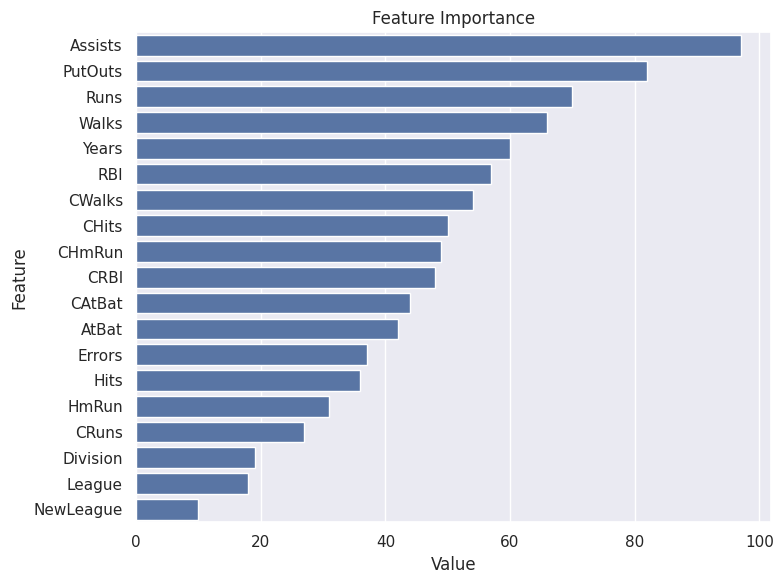

In [27]:
lgbm_model =LGBM_Model(df, "Salary",  test_size=0.20, cv=10, results=True,save_model=True, plot_importance=True)

# Load a Base Model and Then Prediction

In [28]:
def load_model(pklfile):
  model_disc = joblib.load(pklfile)
  return model_disc

In [29]:
model_disc = load_model("lgbm_model.pkl")

In [30]:
new_data = df.sample(1)

In [31]:
new_data

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
282,633,210,6,91,56,59,6,3070,872,19,420,230,274,1,1,367,432,16,90.0,1


In [32]:
new_data_without_salary = new_data.drop("Salary", axis=1)

In [33]:
model_disc.predict(new_data_without_salary)[0]

np.float64(335.2244151683689)

# Model Tuning

In [34]:
def LGBM_Model(dataframe, target,  test_size=0.20, cv=10, results=False,save_model=False, plot_importance=False):
  X = dataframe.drop(target, axis=1)
  y = dataframe[target]
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1)
  lgbm_model = LGBMRegressor(verbosity=-1)
  lgbm_params = {
      "learning_rate" : [0.1,0.05,0.03,0.01],
      "max_depth" : [5,7,9,"auto"],
      "n_estimators" : [100,500,1000,2000],
      "colsample_bytree" : [0.5, 0.75, 1]
  }
  lgbm_cv_model = GridSearchCV(lgbm_model, lgbm_params, cv=cv, verbose=True).fit(X_train, y_train)
  lgbm_tuned = lgbm_model.set_params(**lgbm_cv_model.best_params_).fit(X,y)

  if results:
    mse_train = mean_squared_error(y_train, lgbm_tuned.predict(X_train))
    mse_test = mean_squared_error(y_test, lgbm_tuned.predict(X_test))
    rmse_train = root_mean_squared_error(y_train, lgbm_tuned.predict(X_train))
    rmse_test = root_mean_squared_error(y_test, lgbm_tuned.predict(X_test))
    mae_train = mean_absolute_error(y_train, lgbm_tuned.predict(X_train))
    mae_test = mean_absolute_error(y_test, lgbm_tuned.predict(X_test))
    r2_train = r2_score(y_train, lgbm_tuned.predict(X_train))
    r2_test = r2_score(y_test, lgbm_tuned.predict(X_test))
    cv_result_mse = cross_validate(lgbm_model, X,y, cv=cv, scoring="neg_mean_squared_error")
    cv_result_rmse = cross_validate(lgbm_model, X, y, cv=cv, scoring="neg_root_mean_squared_error")
    print("Best Params: ", lgbm_cv_model.best_params_)
    print("MSE Train: ", "%.3f" % mse_train)
    print("MSE Test: ", "%.3f" % mse_test)
    print("RMSE Train: ", "%.3f" % rmse_train)
    print("RMSE Test: ", "%.3f" % rmse_test)
    print("MAE Train: ", "%.3f" % mae_train)
    print("MAE Test: ", "%.3f" % mae_test)
    print("R2 Train: ", "%.3f" % r2_train)
    print("R2 Test: ", "%.3f" % r2_test)
    print("Cross Validte MSE Score: ", "%.3f" % cv_result_mse["test_score"].mean())
    print("Cross Validte RMSE Score: ", "%.3f" % cv_result_rmse["test_score"].mean())

  if save_model:
    joblib.dump(lgbm_tuned, "lgbm_model_tuned.pkl")

  if plot_importance:
    feature_imp = pd.DataFrame({'Value': lgbm_model.feature_importances_, 'Feature': X.columns}).sort_values(by="Value", ascending=False)
    plt.figure(figsize=(8,6))
    sns.barplot(x="Value", y="Feature", data=feature_imp)
    plt.title("Feature Importance")
    plt.tight_layout()
    plt.savefig("importance.png")
    plt.show()

  return lgbm_tuned

Fitting 10 folds for each of 192 candidates, totalling 1920 fits
Best Params:  {'colsample_bytree': 0.5, 'learning_rate': 0.03, 'max_depth': 9, 'n_estimators': 100}
MSE Train:  42347.103
MSE Test:  57950.976
RMSE Train:  205.784
RMSE Test:  240.730
MAE Train:  125.592
MAE Test:  146.813
R2 Train:  0.713
R2 Test:  0.760
Cross Validte MSE Score:  -83741.851
Cross Validte RMSE Score:  -282.452


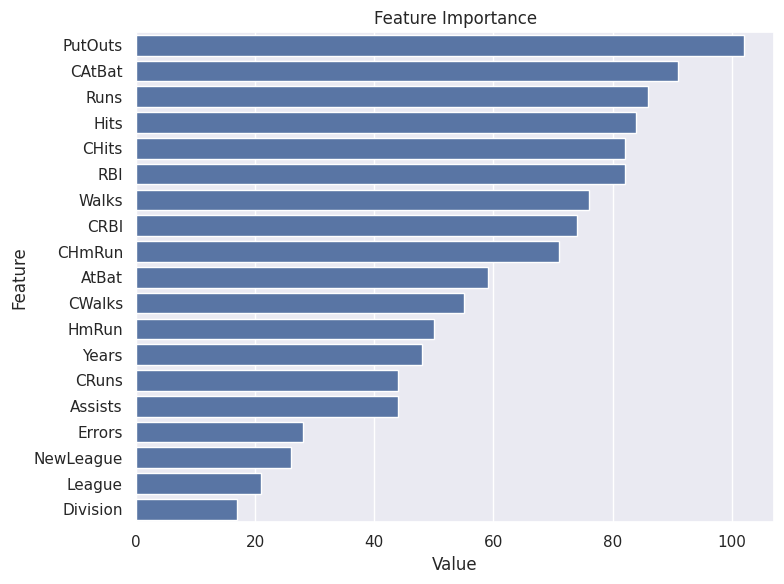

In [35]:
lgbm_tuned = LGBM_Model(df, "Salary",  test_size=0.20, cv=10, results=True,save_model=True, plot_importance=True)

# Load a Base Model and Then Prediction

In [36]:
def load_model(pklfile):
  model_disc = joblib.load(pklfile)
  return model_disc

In [37]:
model_disc = load_model("lgbm_model_tuned.pkl")

In [38]:
new_data

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
282,633,210,6,91,56,59,6,3070,872,19,420,230,274,1,1,367,432,16,90.0,1


In [39]:
new_data_without_salary = new_data.drop("Salary", axis=1)

In [40]:
model_disc.predict(new_data_without_salary)[0]

np.float64(552.2734449538395)

# LGBM Tuned => Other Verison

In [41]:
def LGBM_Model(dataframe, target,  test_size=0.20, cv=10, results=False,save_model=False, plot_importance=False):
  X = dataframe.drop(target, axis=1)
  y = dataframe[target]
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1)
  lgbm_model = LGBMRegressor(verbosity=-1)
  lgbm_params = {
      "learning_rate" : [0.1,0.05,0.03,0.01],
      "max_depth" : [5,7,9,"auto"],
      "n_estimators" : [100,500,1000,2000],
      "colsample_bytree" : [0.5, 0.75, 1]
  }
  lgbm_model_tuned = RandomizedSearchCV(estimators=lgbm_model, param_distributions=lgbm_model, n_iter=100, cv=cv, verbose=True).fit(X,y)

  if results:
    mse_train = mean_squared_error(y_train, lgbm_model_tuned.predict(X_train))
    mse_test = mean_squared_error(y_test, lgbm_model_tuned.predict(X_test))
    rmse_train = root_mean_squared_error(y_train, lgbm_model_tuned.predict(X_train))
    rmse_test = root_mean_squared_error(y_test, lgbm_model_tuned.predict(X_test))
    mae_train = mean_absolute_error(y_train, lgbm_model_tuned.predict(X_train))
    mae_test = mean_absolute_error(y_test, lgbm_model_tuned.predict(X_test))
    r2_train = r2_score(y_train, lgbm_model_tuned.predict(X_train))
    r2_test = r2_score(y_test, lgbm_model_tuned.predict(X_test))
    cv_result_mse = cross_validate(lgbm_model, X,y, cv=cv, scoring="neg_mean_squared_error")
    cv_result_rmse = cross_validate(lgbm_model, X, y, cv=cv, scoring="neg_root_mean_squared_error")
    print("Best Params: ", lgbm_cv_model.best_params_)
    print("MSE Train: ", "%.3f" % mse_train)
    print("MSE Test: ", "%.3f" % mse_test)
    print("RMSE Train: ", "%.3f" % rmse_train)
    print("RMSE Test: ", "%.3f" % rmse_test)
    print("MAE Train: ", "%.3f" % mae_train)
    print("MAE Test: ", "%.3f" % mae_test)
    print("R2 Train: ", "%.3f" % r2_train)
    print("R2 Test: ", "%.3f" % r2_test)
    print("Cross Validte MSE Score: ", "%.3f" % cv_result_mse["test_score"].mean())
    print("Cross Validte RMSE Score: ", "%.3f" % cv_result_rmse["test_score"].mean())

  if save_model:
    joblib.dump(lgbm_model_tuned, "lgbm_model_tuned.pkl")

  if plot_importance:
    feature_imp = pd.DataFrame({'Value': lgbm_model.feature_importances_, 'Feature': X.columns}).sort_values(by="Value", ascending=False)
    plt.figure(figsize=(8,6))
    sns.barplot(x="Value", y="Feature", data=feature_imp)
    plt.title("Feature Importance")
    plt.tight_layout()
    plt.savefig("importance.png")
    plt.show()

  return lgbm_model_tuned